# Homework 1
<span style="font-size:1.25em"> Emre Kara  </span>  
<span style="font-size:1em"> 20.11.2020 </span>

## Libraries, Path and Data Load

Initially, required libraries and data are imported. Data is stored in a folder named *Data* as 3 csv files which belong to the following football seasons of English Premier League:
* 2018-2019
* 2019-2020
* 2020-2021

Files are named as season-end years as two digits appended to the "*data*" label (e.g. *data19.csv*). After csv files are read, loaded data tables are stored in a list variable called **df** and later all data tables are concatenated into a single variable called **dfcombined**. [4]

In [1]:
#Libraries
library(dplyr)
library(data.table)
library(glue)
library(rmarkdown)
library(ggplot2)
library(gridExtra)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'data.table' was built under R version 3.6.3"
Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last


Attaching package: 'glue'

The following object is masked from 'package:dplyr':

    collapse

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [2]:
#R-studio
setwd(dirname(rstudioapi::getSourceEditorContext()$path))

ERROR: Error: RStudio not running


In [3]:
#Dataload
years <- c(19,20,21)
df <- list()
for (i in years){
    df[[length(df) + 1]] <- data.table(read.csv(glue("Data/data{i}.csv")))
}

In [4]:
#Concatenating all three data tables
dfcombined <- rbindlist(df,fill = TRUE); dim(dfcombined); paged_table(dfcombined)

[1] 838 124

Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC.2.5.1,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,11/08/2018,Watford,Brighton,2,0,H,1,0,H,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,11/08/2018,Wolves,Everton,2,2,D,1,1,D,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,12/08/2018,Arsenal,Man City,0,2,A,0,1,A,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,12/08/2018,Liverpool,West Ham,4,0,H,2,0,H,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
E0,12/08/2018,Southampton,Burnley,0,0,D,0,0,D,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Task 1

We check column names in *dfcombined*. For both part 1 and 2, we need two variables: **FTHG** and **FTAG**

In [5]:
transpose(list(colnames(dfcombined)))

[[1]]
[1] "Div"

[[2]]
[1] "Date"

[[3]]
[1] "HomeTeam"

[[4]]
[1] "AwayTeam"

[[5]]
[1] "FTHG"

[[6]]
[1] "FTAG"

[[7]]
[1] "FTR"

[[8]]
[1] "HTHG"

[[9]]
[1] "HTAG"

[[10]]
[1] "HTR"

[[11]]
[1] "Referee"

[[12]]
[1] "HS"

[[13]]
[1] "AS"

[[14]]
[1] "HST"

[[15]]
[1] "AST"

[[16]]
[1] "HF"

[[17]]
[1] "AF"

[[18]]
[1] "HC"

[[19]]
[1] "AC"

[[20]]
[1] "HY"

[[21]]
[1] "AY"

[[22]]
[1] "HR"

[[23]]
[1] "AR"

[[24]]
[1] "B365H"

[[25]]
[1] "B365D"

[[26]]
[1] "B365A"

[[27]]
[1] "BWH"

[[28]]
[1] "BWD"

[[29]]
[1] "BWA"

[[30]]
[1] "IWH"

[[31]]
[1] "IWD"

[[32]]
[1] "IWA"

[[33]]
[1] "PSH"

[[34]]
[1] "PSD"

[[35]]
[1] "PSA"

[[36]]
[1] "WHH"

[[37]]
[1] "WHD"

[[38]]
[1] "WHA"

[[39]]
[1] "VCH"

[[40]]
[1] "VCD"

[[41]]
[1] "VCA"

[[42]]
[1] "Bb1X2"

[[43]]
[1] "BbMxH"

[[44]]
[1] "BbAvH"

[[45]]
[1] "BbMxD"

[[46]]
[1] "BbAvD"

[[47]]
[1] "BbMxA"

[[48]]
[1] "BbAvA"

[[49]]
[1] "BbOU"

[[50]]
[1] "BbMx.2.5"

[[51]]
[1] "BbAv.2.5"

[[52]]
[1] "BbMx.2.5.1"

[[53]]
[1] "BbAv.2.5.1"

[[54]]
[1] "BbAH"

[[55]]
[1] "BbAHh"

[[56]]
[1] "BbMxAHH"

[[57]]
[1] "BbAvAHH"

[[58]]
[1] "BbMxAHA"

[[59]]
[1] "BbAvAHA"

[[60]]
[1] "PSCH"

[[61]]
[1] "PSCD"

[[62]]
[1] "PSCA"

[[63]]
[1] "Time"

[[64]]
[1] "MaxH"

[[65]]
[1] "MaxD"

[[66]]
[1] "MaxA"

[[67]]
[1] "AvgH"

[[68]]
[1] "AvgD"

[[69]]
[1] "AvgA"

[[70]]
[1] "B365.2.5"

[[71]]
[1] "B365.2.5.1"

[[72]]
[1] "P.2.5"

[[73]]
[1] "P.2.5.1"

[[74]]
[1] "Max.2.5"

[[75]]
[1] "Max.2.5.1"

[[76]]
[1] "Avg.2.5"

[[77]]
[1] "Avg.2.5.1"

[[78]]
[1] "AHh"

[[79]]
[1] "B365AHH"

[[80]]
[1] "B365AHA"

[[81]]
[1] "PAHH"

[[82]]
[1] "PAHA"

[[83]]
[1] "MaxAHH"

[[84]]
[1] "MaxAHA"

[[85]]
[1] "AvgAHH"

[[86]]
[1] "AvgAHA"

[[87]]
[1] "B365CH"

[[88]]
[1] "B365CD"

[[89]]
[1] "B365CA"

[[90]]
[1] "BWCH"

[[91]]
[1] "BWCD"

[[92]]
[1] "BWCA"

[[93]]
[1] "IWCH"

[[94]]
[1] "IWCD"

[[95]]
[1] "IWCA"

[[96]]
[1] "WHCH"

[[97]]
[1] "WHCD"

[[98]]
[1] "WHCA"

[[99]]
[1] "VCCH"

[[100]]
[1] "VCCD"

[[101]]
[1] "VCCA"

[[102]]
[1] "MaxCH"

[[103]]
[1] "MaxCD"

[[104]]
[1] "MaxCA"

[[105]]
[1] "AvgCH"

[[106]]
[1] "AvgCD"

[[107]]
[1] "AvgCA"

[[108]]
[1] "B365C.2.5"

[[109]]
[1] "B365C.2.5.1"

[[110]]
[1] "PC.2.5"

[[111]]
[1] "PC.2.5.1"

[[112]]
[1] "MaxC.2.5"

[[113]]
[1] "MaxC.2.5.1"

[[114]]
[1] "AvgC.2.5"

[[115]]
[1] "AvgC.2.5.1"

[[116]]
[1] "AHCh"

[[117]]
[1] "B365CAHH"

[[118]]
[1] "B365CAHA"

[[119]]
[1] "PCAHH"

[[120]]
[1] "PCAHA"

[[121]]
[1] "MaxCAHH"

[[122]]
[1] "MaxCAHA"

[[123]]
[1] "AvgCAHH"

[[124]]
[1] "AvgCAHA"

### Part 1
Histogram plots for

(a) *Home Goals*  
(b) *Away Goals*    
(c) *Home Goals - Away Goals*

can be observed below.

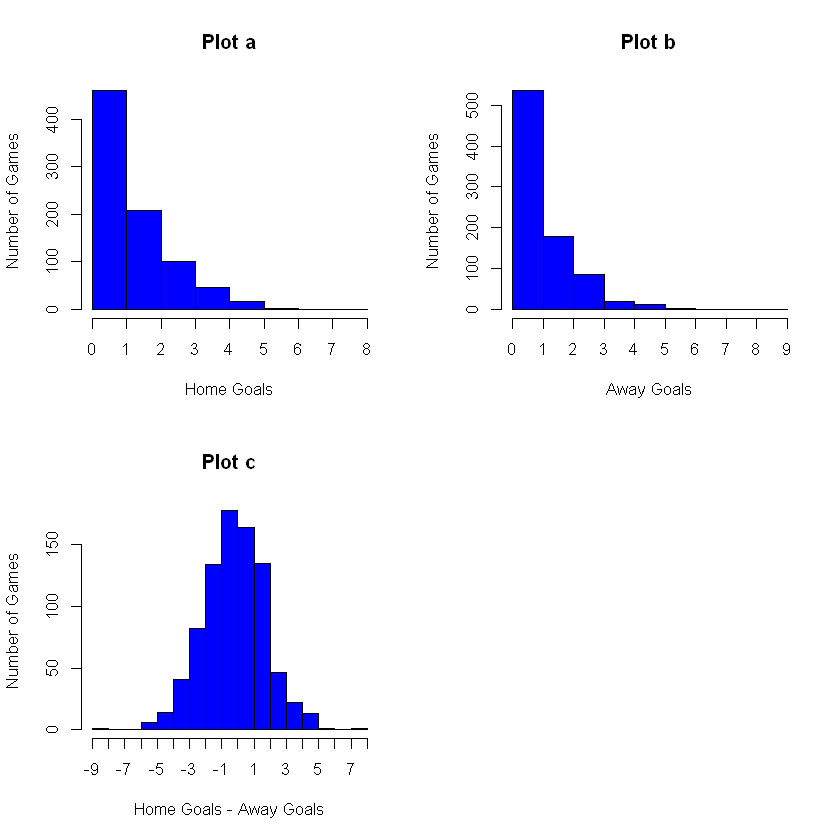

In [6]:
par(mfrow=c(2,2))
hgHome <- hist(dfcombined$FTHG, main = "Plot a", xlab = "Home Goals", ylab = "Number of Games",
    breaks = seq(min(dfcombined$FTHG),max(dfcombined$FTHG)),
    xaxp = c(min(dfcombined$FTHG),max(dfcombined$FTHG),max(dfcombined$FTHG)-min(dfcombined$FTHG)),
    col = "blue")
hgAway <- hist(dfcombined$FTAG, main = "Plot b", xlab = "Away Goals", ylab = "Number of Games",
    breaks = seq(min(dfcombined$FTAG),max(dfcombined$FTAG)),
    xaxp = c(min(dfcombined$FTAG),max(dfcombined$FTAG),max(dfcombined$FTAG)-min(dfcombined$FTAG)),
    col = "blue")
hgDif <- hist(dfcombined$FTHG - dfcombined$FTAG, main = "Plot c", xlab = "Home Goals - Away Goals", ylab = "Number of Games",
    breaks = seq(min(dfcombined$FTHG-dfcombined$FTAG),max(dfcombined$FTHG-dfcombined$FTAG)),
    xaxp = c(min(dfcombined$FTHG-dfcombined$FTAG),max(dfcombined$FTHG-dfcombined$FTAG),
             max(dfcombined$FTHG-dfcombined$FTAG)-min(dfcombined$FTHG-dfcombined$FTAG)),
    col = "blue")

### Part 2
Distributions of home and away goals start with highest frequencies and go down in terms of frequency as number of goals increases. As the observations are discrete, it would be more convenient to compare these histograms with discrete distributions. Examples that would be close to our left skewed data would be:  
- Negative Binomial Distribution
- Binomial Distribuiton
- Poisson Distribution

Modes of both home and away goals equal to **0**. Hence, our expected value for both distributions should be close to 0. For negative binomial distribution, it can be expected that r parameter (number of successes required) to be close to 1 or equal to 1 which corresponds to the geometric distribution for the latter case. For binomial distribution, multiplication of the parameters n\*p should be chosen close to 0. Finally, Poisson distribution with $\lambda$ parameter close to 0 could fit the data as both of them have left skewed shape and mode values between 0 and 1.

#### Generating Theoretical Values

In [7]:
#Calculating Means

smr <- summary(dfcombined[,c("FTHG","FTAG")]);smr

      FTHG            FTAG     
 Min.   :0.000   Min.   :0.00  
 1st Qu.:1.000   1st Qu.:0.00  
 Median :1.000   Median :1.00  
 Mean   :1.536   Mean   :1.27  
 3rd Qu.:2.000   3rd Qu.:2.00  
 Max.   :8.000   Max.   :9.00  

In [8]:
lambdas <- as.numeric(c(strsplit(smr[4,1],":")[[1]][2], strsplit(smr[4,2],":")[[1]][2])); lambdas

[1] 1.536 1.270

In [9]:
# Generating 1000 Random Poisson Variables for Both Lambdas
Goals <- rbind(rpois(1000,lambdas[1]),rpois(1000,lambdas[2])); Goals


2,4,1,4,1,2,0,4,2,2,...,1,0,2,0,1,5,1,3,1,2
1,1,2,3,2,1,1,1,1,2,...,0,0,0,0,0,1,3,1,0,4


#### Plotting Thoretical Histograms

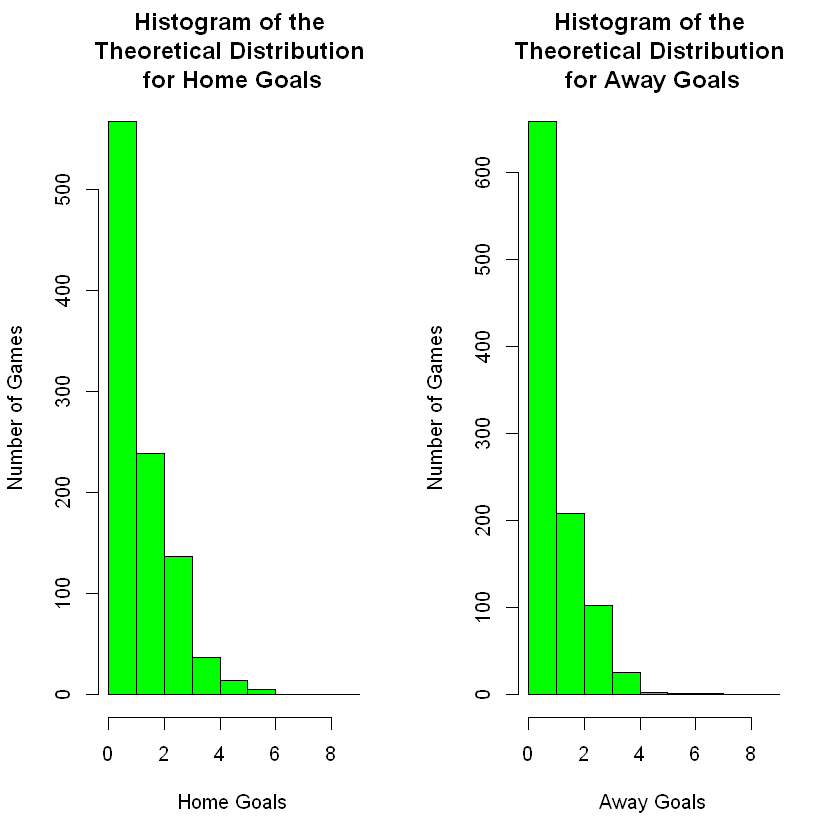

In [10]:
par(mfrow = c(1,2) )
hgHomePois <- hist(Goals[1,],plot = FALSE, breaks = seq(0,9))
hgAwayPois <- hist(Goals[2,],plot = FALSE, breaks = seq(0,9))
plot(hgHomePois, col ="green", xlab = "Home Goals", ylab = "Number of Games",
     main = "Histogram of the \nTheoretical Distribution \nfor Home Goals")
plot(hgAwayPois, col ="green", xlab = "Away Goals", ylab = "Number of Games",
     main = "Histogram of the \nTheoretical Distribution \nfor Away Goals")

#### Comparing Theoretical and Emprical Distributions

Histogram of emprical and theoretical data can be observed together below on the same plots. Frequencies are converted to perentages in these plots to be able to compare both data.
- **Green**: Emprical Data
- **Red**: Theoretical Data
- **Darker Area**: Intersection

From plots, it can be said that the data has a distribution **very similar to the Poisson distribution**.

In [11]:
c1 <- rgb(0,230,10,max = 255, alpha = 70)
c2 <- rgb(150,20,0, max = 255, alpha = 70)

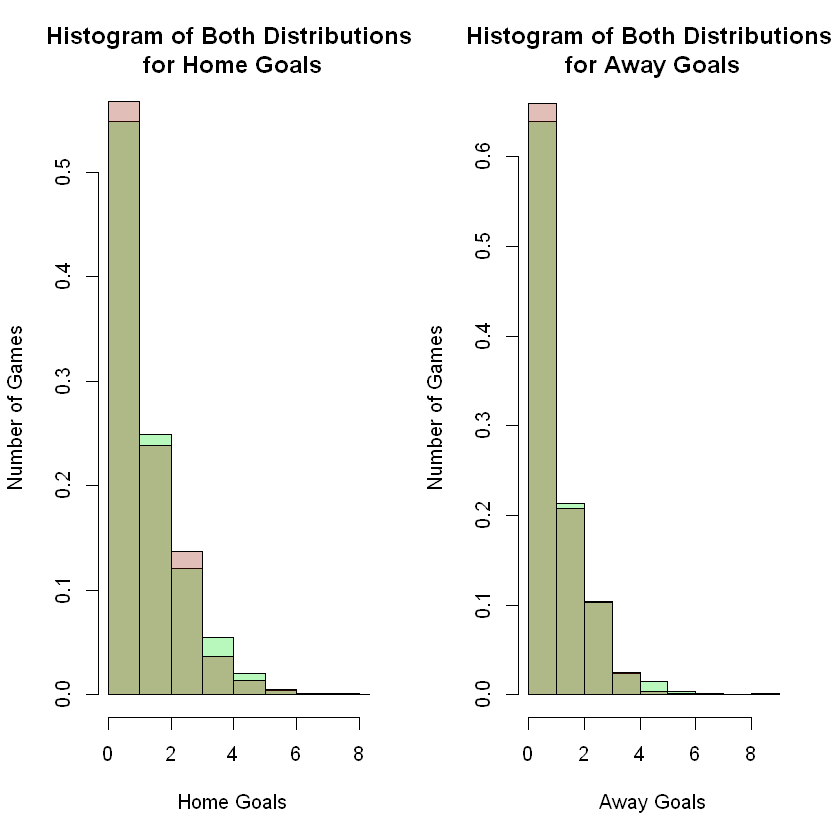

In [12]:
# Plotting Empirical and Theoretical Histograms Together.
par(mfrow = c(1,2))
plot(hgHome,col = c1, freq=FALSE, xlab = "Home Goals", ylab = "Number of Games",
     main = "Histogram of Both Distributions \nfor Home Goals")
plot(hgHomePois, col = c2, freq=FALSE, add = TRUE)

plot(hgAway,col = c1, freq=FALSE, xlab = "Away Goals", ylab = "Number of Games",
     main = "Histogram of Both Distributions \nfor Away Goals")
plot(hgAwayPois, col = c2, freq=FALSE, add = TRUE)

## Task 2

In [13]:
transpose(list(colnames(dfcombined)))

[[1]]
[1] "Div"

[[2]]
[1] "Date"

[[3]]
[1] "HomeTeam"

[[4]]
[1] "AwayTeam"

[[5]]
[1] "FTHG"

[[6]]
[1] "FTAG"

[[7]]
[1] "FTR"

[[8]]
[1] "HTHG"

[[9]]
[1] "HTAG"

[[10]]
[1] "HTR"

[[11]]
[1] "Referee"

[[12]]
[1] "HS"

[[13]]
[1] "AS"

[[14]]
[1] "HST"

[[15]]
[1] "AST"

[[16]]
[1] "HF"

[[17]]
[1] "AF"

[[18]]
[1] "HC"

[[19]]
[1] "AC"

[[20]]
[1] "HY"

[[21]]
[1] "AY"

[[22]]
[1] "HR"

[[23]]
[1] "AR"

[[24]]
[1] "B365H"

[[25]]
[1] "B365D"

[[26]]
[1] "B365A"

[[27]]
[1] "BWH"

[[28]]
[1] "BWD"

[[29]]
[1] "BWA"

[[30]]
[1] "IWH"

[[31]]
[1] "IWD"

[[32]]
[1] "IWA"

[[33]]
[1] "PSH"

[[34]]
[1] "PSD"

[[35]]
[1] "PSA"

[[36]]
[1] "WHH"

[[37]]
[1] "WHD"

[[38]]
[1] "WHA"

[[39]]
[1] "VCH"

[[40]]
[1] "VCD"

[[41]]
[1] "VCA"

[[42]]
[1] "Bb1X2"

[[43]]
[1] "BbMxH"

[[44]]
[1] "BbAvH"

[[45]]
[1] "BbMxD"

[[46]]
[1] "BbAvD"

[[47]]
[1] "BbMxA"

[[48]]
[1] "BbAvA"

[[49]]
[1] "BbOU"

[[50]]
[1] "BbMx.2.5"

[[51]]
[1] "BbAv.2.5"

[[52]]
[1] "BbMx.2.5.1"

[[53]]
[1] "BbAv.2.5.1"

[[54]]
[1] "BbAH"

[[55]]
[1] "BbAHh"

[[56]]
[1] "BbMxAHH"

[[57]]
[1] "BbAvAHH"

[[58]]
[1] "BbMxAHA"

[[59]]
[1] "BbAvAHA"

[[60]]
[1] "PSCH"

[[61]]
[1] "PSCD"

[[62]]
[1] "PSCA"

[[63]]
[1] "Time"

[[64]]
[1] "MaxH"

[[65]]
[1] "MaxD"

[[66]]
[1] "MaxA"

[[67]]
[1] "AvgH"

[[68]]
[1] "AvgD"

[[69]]
[1] "AvgA"

[[70]]
[1] "B365.2.5"

[[71]]
[1] "B365.2.5.1"

[[72]]
[1] "P.2.5"

[[73]]
[1] "P.2.5.1"

[[74]]
[1] "Max.2.5"

[[75]]
[1] "Max.2.5.1"

[[76]]
[1] "Avg.2.5"

[[77]]
[1] "Avg.2.5.1"

[[78]]
[1] "AHh"

[[79]]
[1] "B365AHH"

[[80]]
[1] "B365AHA"

[[81]]
[1] "PAHH"

[[82]]
[1] "PAHA"

[[83]]
[1] "MaxAHH"

[[84]]
[1] "MaxAHA"

[[85]]
[1] "AvgAHH"

[[86]]
[1] "AvgAHA"

[[87]]
[1] "B365CH"

[[88]]
[1] "B365CD"

[[89]]
[1] "B365CA"

[[90]]
[1] "BWCH"

[[91]]
[1] "BWCD"

[[92]]
[1] "BWCA"

[[93]]
[1] "IWCH"

[[94]]
[1] "IWCD"

[[95]]
[1] "IWCA"

[[96]]
[1] "WHCH"

[[97]]
[1] "WHCD"

[[98]]
[1] "WHCA"

[[99]]
[1] "VCCH"

[[100]]
[1] "VCCD"

[[101]]
[1] "VCCA"

[[102]]
[1] "MaxCH"

[[103]]
[1] "MaxCD"

[[104]]
[1] "MaxCA"

[[105]]
[1] "AvgCH"

[[106]]
[1] "AvgCD"

[[107]]
[1] "AvgCA"

[[108]]
[1] "B365C.2.5"

[[109]]
[1] "B365C.2.5.1"

[[110]]
[1] "PC.2.5"

[[111]]
[1] "PC.2.5.1"

[[112]]
[1] "MaxC.2.5"

[[113]]
[1] "MaxC.2.5.1"

[[114]]
[1] "AvgC.2.5"

[[115]]
[1] "AvgC.2.5.1"

[[116]]
[1] "AHCh"

[[117]]
[1] "B365CAHH"

[[118]]
[1] "B365CAHA"

[[119]]
[1] "PCAHH"

[[120]]
[1] "PCAHA"

[[121]]
[1] "MaxCAHH"

[[122]]
[1] "MaxCAHA"

[[123]]
[1] "AvgCAHH"

[[124]]
[1] "AvgCAHA"

For this task, odds from bookmakers and full time results are needed. Needed columns are:

**FTR, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, PSH, PSD, PSA, WHH, WHD, WHA, VCH, VCD, VCA**

In [14]:
dftask2 <- dfcombined[,c("FTR","B365H", "B365D", "B365A", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "PSH", "PSD", "PSA", "WHH", "WHD", "WHA", "VCH", "VCD", "VCA")];head(dftask2)

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA
H,1.57,3.9,7.50,1.53,4.0,7.50,1.55,3.80,7.00,1.58,3.93,7.50,1.57,3.8,6.00,1.57,4.0,7.00
H,1.90,3.6,4.50,1.90,3.4,4.40,1.90,3.50,4.10,1.89,3.63,4.58,1.91,3.5,4.00,1.87,3.6,4.75
A,2.50,3.4,3.00,2.45,3.3,2.95,2.40,3.30,2.95,2.50,3.46,3.00,2.45,3.3,2.80,2.50,3.4,3.00
A,6.50,4.0,1.61,6.25,3.9,1.57,6.20,4.00,1.55,6.41,4.02,1.62,5.80,3.9,1.57,6.50,4.0,1.62
A,3.90,3.5,2.04,3.80,3.5,2.00,3.70,3.35,2.05,3.83,3.57,2.08,3.80,3.2,2.05,3.90,3.4,2.10
H,2.37,3.2,3.40,2.35,3.1,3.30,2.20,3.30,3.40,2.43,3.22,3.33,2.38,3.0,3.30,2.40,3.2,3.40


### Part 1. Probability Calculations

To be able to make calculations, odds are converted to probabilities by inverting them.

In [15]:
# Inverting odds
dftask2[,colnames(dftask2)[-1] := 1/dftask2[,-"FTR"] ] ; head(dftask2)

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA
H,0.6369427,0.2564103,0.1333333,0.6535948,0.2500000,0.1333333,0.6451613,0.2631579,0.1428571,0.6329114,0.2544529,0.1333333,0.6369427,0.2631579,0.1666667,0.6369427,0.2500000,0.1428571
H,0.5263158,0.2777778,0.2222222,0.5263158,0.2941176,0.2272727,0.5263158,0.2857143,0.2439024,0.5291005,0.2754821,0.2183406,0.5235602,0.2857143,0.2500000,0.5347594,0.2777778,0.2105263
A,0.4000000,0.2941176,0.3333333,0.4081633,0.3030303,0.3389831,0.4166667,0.3030303,0.3389831,0.4000000,0.2890173,0.3333333,0.4081633,0.3030303,0.3571429,0.4000000,0.2941176,0.3333333
A,0.1538462,0.2500000,0.6211180,0.1600000,0.2564103,0.6369427,0.1612903,0.2500000,0.6451613,0.1560062,0.2487562,0.6172840,0.1724138,0.2564103,0.6369427,0.1538462,0.2500000,0.6172840
A,0.2564103,0.2857143,0.4901961,0.2631579,0.2857143,0.5000000,0.2702703,0.2985075,0.4878049,0.2610966,0.2801120,0.4807692,0.2631579,0.3125000,0.4878049,0.2564103,0.2941176,0.4761905
H,0.4219409,0.3125000,0.2941176,0.4255319,0.3225806,0.3030303,0.4545455,0.3030303,0.2941176,0.4115226,0.3105590,0.3003003,0.4201681,0.3333333,0.3030303,0.4166667,0.3125000,0.2941176


### Part 2. Normalized Probabilities

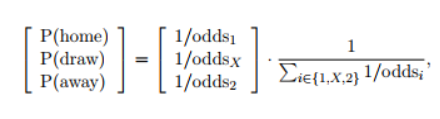

First, bookkeeper names are extracted from column names by omitting last character of them. **6 unique bookkeepers** are obtained after this operation.  Later, all probability values are normalized by dividing them with sums of all probabilites belonging to each bookmaker respectively. The formula above is used as a reference for probability calculations. [2][3]

In [16]:
# Bookkeeper names
bks <- substr(colnames(dftask2)[-1],1,nchar(colnames(dftask2)[-1])-1)
bksUnique <- unique(bks)
bks <- append("FTR",bks)
bks;bksUnique

[1] "FTR"  "B365" "B365" "B365" "BW"   "BW"   "BW"   "IW"   "IW"   "IW"  
[11] "PS"   "PS"   "PS"   "WH"   "WH"   "WH"   "VC"   "VC"   "VC"

[1] "B365" "BW"   "IW"   "PS"   "WH"   "VC"

In [17]:
# All totals are calculated and saved into columns with bookkeeper names
for (b in bksUnique){
    cols <- grepl(b,bks)
    sums <- rowSums( dftask2[,..cols] )
    newcolname <- paste(b,"Tot",sep="")
    dftask2[,newcolname] <- sums
}
paged_table(head(dftask2))

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,WHA,VCH,VCD,VCA,B365Tot,BWTot,IWTot,PSTot,WHTot,VCTot
H,0.6369427,0.2564103,0.1333333,0.6535948,0.2500000,0.1333333,0.6451613,0.2631579,0.1428571,...,0.1666667,0.6369427,0.2500000,0.1428571,1.026686,1.036928,1.051176,1.020698,1.066767,1.029800
H,0.5263158,0.2777778,0.2222222,0.5263158,0.2941176,0.2272727,0.5263158,0.2857143,0.2439024,...,0.2500000,0.5347594,0.2777778,0.2105263,1.026316,1.047706,1.055933,1.022923,1.059274,1.023063
A,0.4000000,0.2941176,0.3333333,0.4081633,0.3030303,0.3389831,0.4166667,0.3030303,0.3389831,...,0.3571429,0.4000000,0.2941176,0.3333333,1.027451,1.050177,1.058680,1.022351,1.068336,1.027451
A,0.1538462,0.2500000,0.6211180,0.1600000,0.2564103,0.6369427,0.1612903,0.2500000,0.6451613,...,0.6369427,0.1538462,0.2500000,0.6172840,1.024964,1.053353,1.056452,1.022046,1.065767,1.021130
A,0.2564103,0.2857143,0.4901961,0.2631579,0.2857143,0.5000000,0.2702703,0.2985075,0.4878049,...,0.4878049,0.2564103,0.2941176,0.4761905,1.032321,1.048872,1.056583,1.021978,1.063463,1.026718
H,0.4219409,0.3125000,0.2941176,0.4255319,0.3225806,0.3030303,0.4545455,0.3030303,0.2941176,...,0.3030303,0.4166667,0.3125000,0.2941176,1.028559,1.051143,1.051693,1.022382,1.056532,1.023284


In [18]:
# Probability Normalization
for (b in bksUnique){
    cols <-grepl(b,bks)
    cols[length(cols)+1:length(colnames(dftask2))] <- FALSE
    cols <- which(cols %in% TRUE)
    newcolnames <- paste(colnames(dftask2)[cols],"NormP",sep="")
    TotCol <- paste(b,"Tot",sep="")
    dftask2[,newcolnames] <- dftask2[,..cols]/dftask2[,c(..TotCol, ..TotCol, ..TotCol)]
}
paged_table(head(dftask2)); transpose(list(colnames(dftask2)))

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,IWANormP,PSHNormP,PSDNormP,PSANormP,WHHNormP,WHDNormP,WHANormP,VCHNormP,VCDNormP,VCANormP
H,0.6369427,0.2564103,0.1333333,0.6535948,0.2500000,0.1333333,0.6451613,0.2631579,0.1428571,...,0.1359022,0.6200772,0.2492931,0.1306296,0.5970775,0.2466873,0.1562353,0.6185112,0.2427656,0.1387232
H,0.5263158,0.2777778,0.2222222,0.5263158,0.2941176,0.2272727,0.5263158,0.2857143,0.2439024,...,0.2309830,0.5172436,0.2693087,0.2134477,0.4942630,0.2697264,0.2360106,0.5227040,0.2715157,0.2057803
A,0.4000000,0.2941176,0.3333333,0.4081633,0.3030303,0.3389831,0.4166667,0.3030303,0.3389831,...,0.3201941,0.3912552,0.2826988,0.3260460,0.3820550,0.2836469,0.3342981,0.3893130,0.2862595,0.3244275
A,0.1538462,0.2500000,0.6211180,0.1600000,0.2564103,0.6369427,0.1612903,0.2500000,0.6451613,...,0.6106870,0.1526411,0.2433903,0.6039686,0.1617744,0.2405876,0.5976380,0.1506626,0.2448268,0.6045106
A,0.2564103,0.2857143,0.4901961,0.2631579,0.2857143,0.5000000,0.2702703,0.2985075,0.4878049,...,0.4616817,0.2554817,0.2740882,0.4704302,0.2474538,0.2938514,0.4586948,0.2497377,0.2864638,0.4637985
H,0.4219409,0.3125000,0.2941176,0.4255319,0.3225806,0.3030303,0.4545455,0.3030303,0.2941176,...,0.2796610,0.4025136,0.3037603,0.2937261,0.3976862,0.3154977,0.2868161,0.4071856,0.3053892,0.2874251


[[1]]
[1] "FTR"

[[2]]
[1] "B365H"

[[3]]
[1] "B365D"

[[4]]
[1] "B365A"

[[5]]
[1] "BWH"

[[6]]
[1] "BWD"

[[7]]
[1] "BWA"

[[8]]
[1] "IWH"

[[9]]
[1] "IWD"

[[10]]
[1] "IWA"

[[11]]
[1] "PSH"

[[12]]
[1] "PSD"

[[13]]
[1] "PSA"

[[14]]
[1] "WHH"

[[15]]
[1] "WHD"

[[16]]
[1] "WHA"

[[17]]
[1] "VCH"

[[18]]
[1] "VCD"

[[19]]
[1] "VCA"

[[20]]
[1] "B365Tot"

[[21]]
[1] "BWTot"

[[22]]
[1] "IWTot"

[[23]]
[1] "PSTot"

[[24]]
[1] "WHTot"

[[25]]
[1] "VCTot"

[[26]]
[1] "B365HNormP"

[[27]]
[1] "B365DNormP"

[[28]]
[1] "B365ANormP"

[[29]]
[1] "BWHNormP"

[[30]]
[1] "BWDNormP"

[[31]]
[1] "BWANormP"

[[32]]
[1] "IWHNormP"

[[33]]
[1] "IWDNormP"

[[34]]
[1] "IWANormP"

[[35]]
[1] "PSHNormP"

[[36]]
[1] "PSDNormP"

[[37]]
[1] "PSANormP"

[[38]]
[1] "WHHNormP"

[[39]]
[1] "WHDNormP"

[[40]]
[1] "WHANormP"

[[41]]
[1] "VCHNormP"

[[42]]
[1] "VCDNormP"

[[43]]
[1] "VCANormP"

### Part 3 and 4

Probabilities are plotted in three steps in this part:
- Calculating P(Home)-P(Away) values for eachbookmaker.
- Splitting difference values into bins with 0.1 width for eachbookmaker
- Counting total number of games and number of games that ended in draw for each bin
- Plotting emprical percentages and bookkeeper probabilities

#### P(Home)-P(Away) Calculation

In [19]:
# Calculating P(Home)-P(Away) Columns with Adjusted Probabilities
for (b in bksUnique){
    newcolnames <- paste(b,"DiffNormP",sep="")
    homecol <- paste(b,"HNormP",sep="")
    awaycol <- paste(b,"ANormP",sep="")
    dftask2[,newcolnames] <- dftask2[,..homecol] - dftask2[,..awaycol]
}
paged_table(head(dftask2)); transpose(list(colnames(dftask2)))

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,WHANormP,VCHNormP,VCDNormP,VCANormP,B365DiffNormP,BWDiffNormP,IWDiffNormP,PSDiffNormP,WHDiffNormP,VCDiffNormP
H,0.6369427,0.2564103,0.1333333,0.6535948,0.2500000,0.1333333,0.6451613,0.2631579,0.1428571,...,0.1562353,0.6185112,0.2427656,0.1387232,0.4905192,0.50173338,0.4778496,0.4894476,0.44084219,0.4797879
H,0.5263158,0.2777778,0.2222222,0.5263158,0.2941176,0.2272727,0.5263158,0.2857143,0.2439024,...,0.2360106,0.5227040,0.2715157,0.2057803,0.2962963,0.28542646,0.2674540,0.3037959,0.25825243,0.3169237
A,0.4000000,0.2941176,0.3333333,0.4081633,0.3030303,0.3389831,0.4166667,0.3030303,0.3389831,...,0.3342981,0.3893130,0.2862595,0.3244275,0.0648855,0.06587484,0.0733778,0.0652092,0.04775687,0.0648855
A,0.1538462,0.2500000,0.6211180,0.1600000,0.2564103,0.6369427,0.1612903,0.2500000,0.6451613,...,0.5976380,0.1506626,0.2448268,0.6045106,-0.4558909,-0.45278525,-0.4580153,-0.4513276,-0.43586356,-0.4538479
A,0.2564103,0.2857143,0.4901961,0.2631579,0.2857143,0.5000000,0.2702703,0.2985075,0.4878049,...,0.4586948,0.2497377,0.2864638,0.4637985,-0.2264663,-0.22580645,-0.2058851,-0.2149485,-0.21124104,-0.2140609
H,0.4219409,0.3125000,0.2941176,0.4255319,0.3225806,0.3030303,0.4545455,0.3030303,0.2941176,...,0.2868161,0.4071856,0.3053892,0.2874251,0.1242742,0.11654135,0.1525424,0.1087875,0.11087009,0.1197605


[[1]]
[1] "FTR"

[[2]]
[1] "B365H"

[[3]]
[1] "B365D"

[[4]]
[1] "B365A"

[[5]]
[1] "BWH"

[[6]]
[1] "BWD"

[[7]]
[1] "BWA"

[[8]]
[1] "IWH"

[[9]]
[1] "IWD"

[[10]]
[1] "IWA"

[[11]]
[1] "PSH"

[[12]]
[1] "PSD"

[[13]]
[1] "PSA"

[[14]]
[1] "WHH"

[[15]]
[1] "WHD"

[[16]]
[1] "WHA"

[[17]]
[1] "VCH"

[[18]]
[1] "VCD"

[[19]]
[1] "VCA"

[[20]]
[1] "B365Tot"

[[21]]
[1] "BWTot"

[[22]]
[1] "IWTot"

[[23]]
[1] "PSTot"

[[24]]
[1] "WHTot"

[[25]]
[1] "VCTot"

[[26]]
[1] "B365HNormP"

[[27]]
[1] "B365DNormP"

[[28]]
[1] "B365ANormP"

[[29]]
[1] "BWHNormP"

[[30]]
[1] "BWDNormP"

[[31]]
[1] "BWANormP"

[[32]]
[1] "IWHNormP"

[[33]]
[1] "IWDNormP"

[[34]]
[1] "IWANormP"

[[35]]
[1] "PSHNormP"

[[36]]
[1] "PSDNormP"

[[37]]
[1] "PSANormP"

[[38]]
[1] "WHHNormP"

[[39]]
[1] "WHDNormP"

[[40]]
[1] "WHANormP"

[[41]]
[1] "VCHNormP"

[[42]]
[1] "VCDNormP"

[[43]]
[1] "VCANormP"

[[44]]
[1] "B365DiffNormP"

[[45]]
[1] "BWDiffNormP"

[[46]]
[1] "IWDiffNormP"

[[47]]
[1] "PSDiffNormP"

[[48]]
[1] "WHDiffNormP"

[[49]]
[1] "VCDiffNormP"

#### Creating Bin

In [20]:
# Function for creating bins. Bins will be recorded as floats which will have center values
makebins <- function(x,lbv,ubv){
    #lbv ... lower border vector
    #ubv ... upper border vector
    res <- rep("?",length(x));
    for(i in 1:length(lbv)){
        res[ x>=lbv[i] & x<ubv[i] ]<- round((lbv[i] + ubv[i])/2,2)
    }
    return(res)
}

In [21]:
# Limits of bins. Bins will be created as [lb,ub)
lbv <- seq(-1,0.9,0.1); ubv <- round(lbv +0.1,1); lbv;ubv

[1] -1.0 -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.0  0.1  0.2  0.3  0.4
[16]  0.5  0.6  0.7  0.8  0.9

[1] -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.0  0.1  0.2  0.3  0.4  0.5
[16]  0.6  0.7  0.8  0.9  1.0

In [22]:
# Adding bin columns
for (b in bksUnique){
    newcolnames <- paste(b,"Bin",sep="")
    drawcol <- paste(b,"DiffNormP",sep="")
    dftask2[,newcolnames] <- makebins(dftask2[,..drawcol],lbv,ubv)
}
paged_table(head(dftask2))

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,IWDiffNormP,PSDiffNormP,WHDiffNormP,VCDiffNormP,B365Bin,BWBin,IWBin,PSBin,WHBin,VCBin
H,0.6369427,0.2564103,0.1333333,0.6535948,0.2500000,0.1333333,0.6451613,0.2631579,0.1428571,...,0.4778496,0.4894476,0.44084219,0.4797879,0.45,0.55,0.45,0.45,0.45,0.45
H,0.5263158,0.2777778,0.2222222,0.5263158,0.2941176,0.2272727,0.5263158,0.2857143,0.2439024,...,0.2674540,0.3037959,0.25825243,0.3169237,0.25,0.25,0.25,0.35,0.25,0.35
A,0.4000000,0.2941176,0.3333333,0.4081633,0.3030303,0.3389831,0.4166667,0.3030303,0.3389831,...,0.0733778,0.0652092,0.04775687,0.0648855,0.05,0.05,0.05,0.05,0.05,0.05
A,0.1538462,0.2500000,0.6211180,0.1600000,0.2564103,0.6369427,0.1612903,0.2500000,0.6451613,...,-0.4580153,-0.4513276,-0.43586356,-0.4538479,-0.45,-0.45,-0.45,-0.45,-0.45,-0.45
A,0.2564103,0.2857143,0.4901961,0.2631579,0.2857143,0.5000000,0.2702703,0.2985075,0.4878049,...,-0.2058851,-0.2149485,-0.21124104,-0.2140609,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
H,0.4219409,0.3125000,0.2941176,0.4255319,0.3225806,0.3030303,0.4545455,0.3030303,0.2941176,...,0.1525424,0.1087875,0.11087009,0.1197605,0.15,0.15,0.15,0.15,0.15,0.15


In [23]:
# Checking NA Counts
sum(colSums(is.na(dftask2)))

[1] 0

#### Counting Draws and Total Games

In [24]:
binnames <- (lbv+ubv)/2;binnames

[1] -0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15
[13]  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95

In [25]:
cols <-grepl("Bin", colnames(dftask2) )
cols <- which(cols %in% TRUE)
counts <- list()
for (b in cols){
    table <- data.frame()
    for(bin in binnames){
        tablename <- paste(colnames(dftask2)[b],"s",sep="")
        Dvalue = sum( dftask2[, dftask2[,b,with=FALSE] == bin & dftask2[,"FTR"] == "D"]  )
        Tvalue = sum( dftask2[, dftask2[,b,with=FALSE] == bin]  )
        table [ as.character(bin), "Total" ] <- Tvalue
        table [as.character(bin), "Draw" ] <- Dvalue
    }
    counts[[tablename]] <- table
}
counts

,Total,Draw
-0.95,0,0
-0.85,2,0
-0.75,12,1
-0.65,27,2
-0.55,23,4
-0.45,35,4
-0.35,41,7
-0.25,41,10
-0.15,46,8
-0.05,68,15


#### Drawing Plots

In [26]:
for (name in names(counts)){
    counts[[name]][,"EmpricalProbs"] = round(counts[[name]][,"Draw"] / (counts[[name]][,"Total"]+ 1e-05),4)
    
}
counts[["B365Bins"]]

,Total,Draw,EmpricalProbs
-0.95,0,0,0.0000
-0.85,2,0,0.0000
-0.75,12,1,0.0833
-0.65,27,2,0.0741
-0.55,23,4,0.1739
-0.45,35,4,0.1143
-0.35,41,7,0.1707
-0.25,41,10,0.2439
-0.15,46,8,0.1739
-0.05,68,15,0.2206


In [27]:
rownames(counts[["B365Bins"]])

[1] "-0.95" "-0.85" "-0.75" "-0.65" "-0.55" "-0.45" "-0.35" "-0.25" "-0.15"
[10] "-0.05" "0.05"  "0.15"  "0.25"  "0.35"  "0.45"  "0.55"  "0.65"  "0.75" 
[19] "0.85"  "0.95"

In [28]:
transpose(list(colnames(dftask2)))

[[1]]
[1] "FTR"

[[2]]
[1] "B365H"

[[3]]
[1] "B365D"

[[4]]
[1] "B365A"

[[5]]
[1] "BWH"

[[6]]
[1] "BWD"

[[7]]
[1] "BWA"

[[8]]
[1] "IWH"

[[9]]
[1] "IWD"

[[10]]
[1] "IWA"

[[11]]
[1] "PSH"

[[12]]
[1] "PSD"

[[13]]
[1] "PSA"

[[14]]
[1] "WHH"

[[15]]
[1] "WHD"

[[16]]
[1] "WHA"

[[17]]
[1] "VCH"

[[18]]
[1] "VCD"

[[19]]
[1] "VCA"

[[20]]
[1] "B365Tot"

[[21]]
[1] "BWTot"

[[22]]
[1] "IWTot"

[[23]]
[1] "PSTot"

[[24]]
[1] "WHTot"

[[25]]
[1] "VCTot"

[[26]]
[1] "B365HNormP"

[[27]]
[1] "B365DNormP"

[[28]]
[1] "B365ANormP"

[[29]]
[1] "BWHNormP"

[[30]]
[1] "BWDNormP"

[[31]]
[1] "BWANormP"

[[32]]
[1] "IWHNormP"

[[33]]
[1] "IWDNormP"

[[34]]
[1] "IWANormP"

[[35]]
[1] "PSHNormP"

[[36]]
[1] "PSDNormP"

[[37]]
[1] "PSANormP"

[[38]]
[1] "WHHNormP"

[[39]]
[1] "WHDNormP"

[[40]]
[1] "WHANormP"

[[41]]
[1] "VCHNormP"

[[42]]
[1] "VCDNormP"

[[43]]
[1] "VCANormP"

[[44]]
[1] "B365DiffNormP"

[[45]]
[1] "BWDiffNormP"

[[46]]
[1] "IWDiffNormP"

[[47]]
[1] "PSDiffNormP"

[[48]]
[1] "WHDiffNormP"

[[49]]
[1] "VCDiffNormP"

[[50]]
[1] "B365Bin"

[[51]]
[1] "BWBin"

[[52]]
[1] "IWBin"

[[53]]
[1] "PSBin"

[[54]]
[1] "WHBin"

[[55]]
[1] "VCBin"

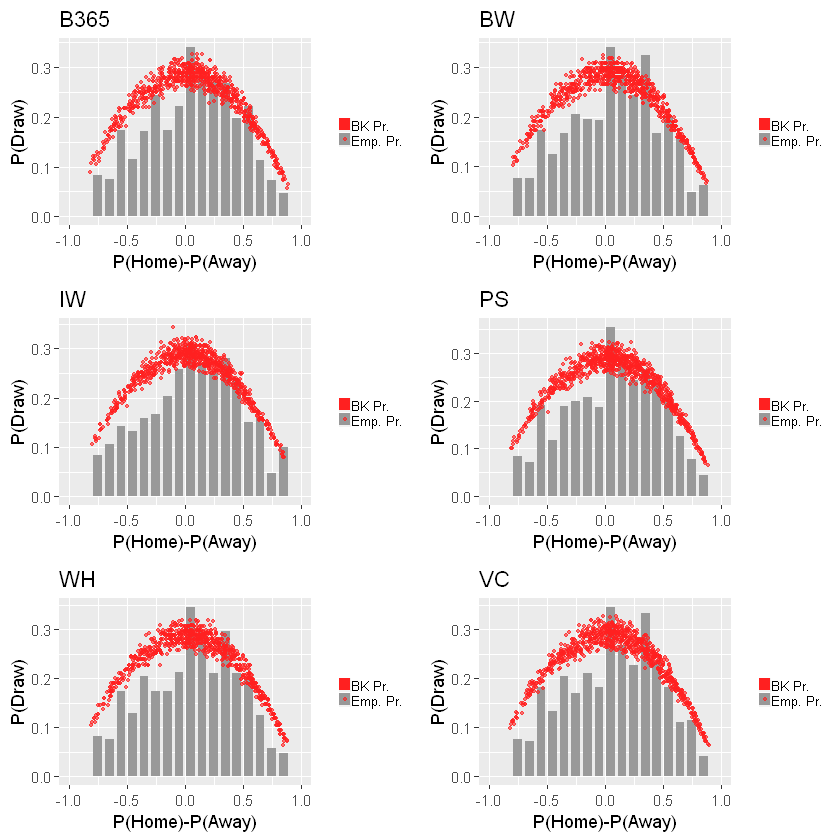

In [154]:
fig <- list()
for (bk in bksUnique){
    xvar1 <- paste(bk,"DiffNormP",sep="")
    yvar1 <- paste(bk,"DNormP",sep="")
    data1 <- dftask2[,c(..xvar1,..yvar1)]
    
    bkbins <- paste(bk,"Bins",sep="")
    xvar2 <- as.numeric(rownames(counts[[bkbins]]))
    yvar2 <- as.numeric(transpose(counts[[bkbins]]["EmpricalProbs"]))
    data2 <- data.table(xvar2 = xvar2,yvar2 = yvar2)

    fig[[length(fig)+1]] <- ggplot() +
        geom_col(data = data2, aes(xvar2,yvar2, fill=rep("Emp. Pr.",length(xvar2))),width = 0.075) +
    
        geom_point(data = data1, aes_string(xvar1,yvar1),col="#ff2020",size= 0.7 ,alpha = 0.6) + 
        aes(fill = rep("BK Pr.",length(xvar1))) +
    
        ylab("P(Draw)") + xlab("P(Home)-P(Away)") + ggtitle(bk) +
        scale_fill_manual(values = c("#ff2020","#999999")) +
        theme(strip.switch.pad.grid =  ) +
    
        theme(legend.title = element_blank(),legend.position = "right",legend.text = element_text(size = 8)) +
        theme(legend.key.size = unit(8,"pt")) +
        theme(panel.spacing = unit(c(0,0,0,0),"pt"),legend.spacing = unit(c(0,0,0,0)  ,"pt"))
}

do.call("grid.arrange", c(fig, ncol=2))


We have plotted implied draw probabilities versus implied P(Home)-P(Away) values both obtained from odds and emprical draw probabilities belonging to each bin. For all bookkepers, plots seem to be in a correllation but there are some local deviations.

**B365**  
Results belonging to the upper half seem fitting very well but in the lower half there are some oscillations. For interval **[-0.2, 0.0]**, there seems to be a sharp decrease in observed draw percentages. Other than that, observations seem to be less than implied probabilities overall except intervals **[-0.6, -0.5]** and  
**[-0.3, -0.2]**.

**BW**  
Draw probabilities of BW also seem to be overestimated for negative x values. There are also two intervals in which observed draw percentages surpassed bookkeepers probabilities which are **[0.0, 0.1]** and **[0.3, 0.4]**.

**IW**  
This bookkeeper seems to have overestimated draws for all bins for negative differences. For positive x values, estimations seem quite accurate except for the interval **[0.8, 0.9]** in which observed probability is quite smaller than bookkeeper probability.

**PS**  
Lower half emprical probabilities are again less than probabilities of PS(Pinnacle) and upper half probabilities seem fitting well the observations. **[0.0, 0.1]** interval is worth notice here. Observed percentages seem higher in this interval and implied probabilities seem negatively biased here.

**WH**  
Implied probabilites of this bookkeeper look like they are overestimating draws generally. Estimations in **[-0.5, 0.6]**, **[0.4, 0.5]** and **[0.5, 0.6]** bins look closest ones to the respetive emprical probabilites. Other than those, implied probabilities seem underestimating in **[0.0, 0.1]** and **[0.3, 0.4]** intervals.

**VC**  
Emprical draw probabilities for negative x values are quite below of the implied probabilities for this bookkeeper as well. Two bins drawing attention with negative bias are **[0.0, 0.1]** and **[0.3, 0.4]**. Draw odds seem to be underestimating for these intervals and can be profitable for bets.

## Task 3

This task will follow same steps of the previous one. The only difference will be that the matches having at least one red card will be removed.

#### Filtering Data

In [163]:
table(dfcombined[,c("HR","AR")]); length(transpose(dfcombined)) #741 matches will remain out of 838

   AR
HR    0   1   2
  0 741  53   1
  1  39   3   0
  2   1   0   0

[1] 838

In [166]:
idx <- dfcombined[,"HR"] == 0 & dfcombined[,"AR"] == 0
idx <- which(idx %in% TRUE)
dftask3 <- dfcombined[idx,c("FTR","B365H", "B365D", "B365A", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "PSH", "PSD", "PSA", "WHH", "WHD", "WHA", "VCH", "VCD", "VCA")]
length(transpose(dftask3))

[1] 741

#### Obtaining Emprical and Implied Probabilities

In [168]:
# Inverting odds
dftask3[,colnames(dftask3)[-1] := 1/dftask3[,-"FTR"] ]

# All totals are calculated and saved into columns with bookkeeper names
for (b in bksUnique){
    cols <- grepl(b,bks)
    sums <- rowSums( dftask3[,..cols] )
    newcolname <- paste(b,"Tot",sep="")
    dftask3[,newcolname] <- sums
}

# Probability Normalization
for (b in bksUnique){
    cols <-grepl(b,bks)
    cols[length(cols)+1:length(colnames(dftask3))] <- FALSE
    cols <- which(cols %in% TRUE)
    newcolnames <- paste(colnames(dftask3)[cols],"NormP",sep="")
    TotCol <- paste(b,"Tot",sep="")
    dftask3[,newcolnames] <- dftask3[,..cols]/dftask3[,c(..TotCol, ..TotCol, ..TotCol)]
}
# Calculating P(Home)-P(Away) Columns with Adjusted Probabilities
for (b in bksUnique){
    newcolnames <- paste(b,"DiffNormP",sep="")
    homecol <- paste(b,"HNormP",sep="")
    awaycol <- paste(b,"ANormP",sep="")
    dftask3[,newcolnames] <- dftask3[,..homecol] - dftask3[,..awaycol]
}
# Adding bin columns
for (b in bksUnique){
    newcolnames <- paste(b,"Bin",sep="")
    drawcol <- paste(b,"DiffNormP",sep="")
    dftask3[,newcolnames] <- makebins(dftask3[,..drawcol],lbv,ubv)
}
paged_table(head(dftask3))

FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,IWDiffNormP,PSDiffNormP,WHDiffNormP,VCDiffNormP,B365Bin,BWBin,IWBin,PSBin,WHBin,VCBin
H,0.6369427,0.2564103,0.1333333,0.6535948,0.2500000,0.1333333,0.6451613,0.2631579,0.1428571,...,0.4778496,0.4894476,0.44084219,0.4797879,0.45,0.55,0.45,0.45,0.45,0.45
H,0.5263158,0.2777778,0.2222222,0.5263158,0.2941176,0.2272727,0.5263158,0.2857143,0.2439024,...,0.2674540,0.3037959,0.25825243,0.3169237,0.25,0.25,0.25,0.35,0.25,0.35
A,0.4000000,0.2941176,0.3333333,0.4081633,0.3030303,0.3389831,0.4166667,0.3030303,0.3389831,...,0.0733778,0.0652092,0.04775687,0.0648855,0.05,0.05,0.05,0.05,0.05,0.05
A,0.1538462,0.2500000,0.6211180,0.1600000,0.2564103,0.6369427,0.1612903,0.2500000,0.6451613,...,-0.4580153,-0.4513276,-0.43586356,-0.4538479,-0.45,-0.45,-0.45,-0.45,-0.45,-0.45
A,0.2564103,0.2857143,0.4901961,0.2631579,0.2857143,0.5000000,0.2702703,0.2985075,0.4878049,...,-0.2058851,-0.2149485,-0.21124104,-0.2140609,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
H,0.4219409,0.3125000,0.2941176,0.4255319,0.3225806,0.3030303,0.4545455,0.3030303,0.2941176,...,0.1525424,0.1087875,0.11087009,0.1197605,0.15,0.15,0.15,0.15,0.15,0.15


In [170]:
# Checking NA Counts
sum(colSums(is.na(dftask3))); length(transpose(dftask3))

[1] 0

[1] 741

In [173]:
cols <-grepl("Bin", colnames(dftask3) )
cols <- which(cols %in% TRUE)
counts <- list()
for (b in cols){
    table <- data.frame()
    for(bin in binnames){
        tablename <- paste(colnames(dftask3)[b],"s",sep="")
        Dvalue = sum( dftask3[, dftask3[,b,with=FALSE] == bin & dftask3[,"FTR"] == "D"]  )
        Tvalue = sum( dftask3[, dftask3[,b,with=FALSE] == bin]  )
        table [ as.character(bin), "Total" ] <- Tvalue
        table [as.character(bin), "Draw" ] <- Dvalue
    }
    counts[[tablename]] <- table
}
for (name in names(counts)){
    counts[[name]][,"EmpricalProbs"] = round(counts[[name]][,"Draw"] / (counts[[name]][,"Total"]+ 1e-05),4)
    
}
counts

,Total,Draw,EmpricalProbs
-0.95,0,0,0.0000
-0.85,2,0,0.0000
-0.75,12,1,0.0833
-0.65,25,2,0.0800
-0.55,21,4,0.1905
-0.45,32,4,0.1250
-0.35,40,7,0.1750
-0.25,33,7,0.2121
-0.15,40,8,0.2000
-0.05,50,9,0.1800


#### Drawing Plots

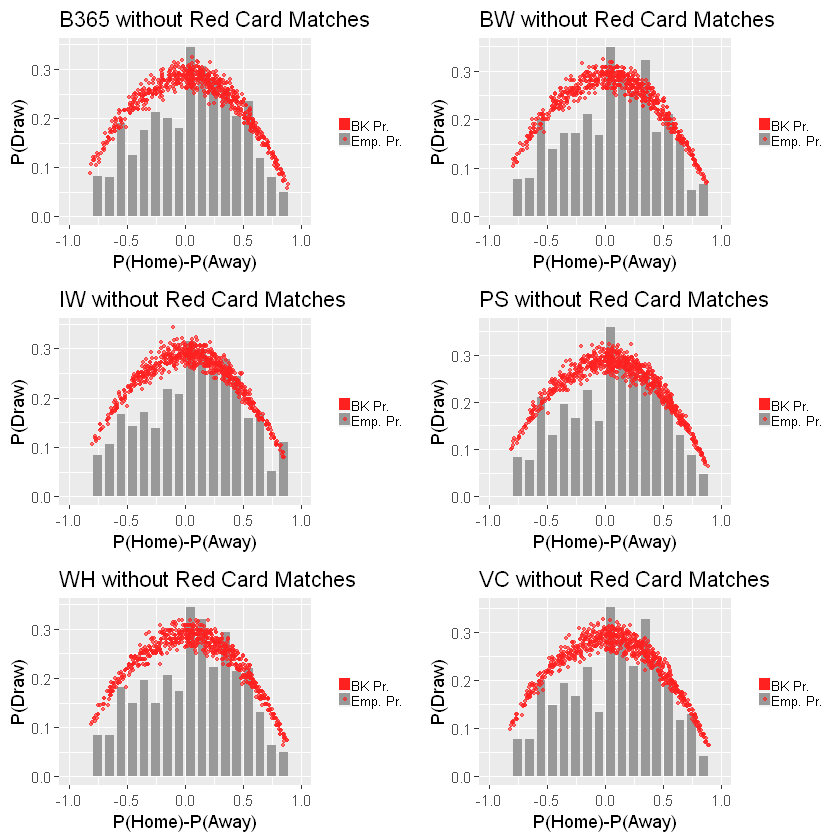

In [175]:
fig <- list()
for (bk in bksUnique){
    xvar1 <- paste(bk,"DiffNormP",sep="")
    yvar1 <- paste(bk,"DNormP",sep="")
    data1 <- dftask3[,c(..xvar1,..yvar1)]
    
    bkbins <- paste(bk,"Bins",sep="")
    xvar2 <- as.numeric(rownames(counts[[bkbins]]))
    yvar2 <- as.numeric(transpose(counts[[bkbins]]["EmpricalProbs"]))
    data2 <- data.table(xvar2 = xvar2,yvar2 = yvar2)

    fig[[length(fig)+1]] <- ggplot() +
        geom_col(data = data2, aes(xvar2,yvar2, fill=rep("Emp. Pr.",length(xvar2))),width = 0.075) +
    
        geom_point(data = data1, aes_string(xvar1,yvar1),col="#ff2020",size= 0.7 ,alpha = 0.6) + 
        aes(fill = rep("BK Pr.",length(xvar1))) +
    
        ylab("P(Draw)") + xlab("P(Home)-P(Away)") + ggtitle(paste(bk,"without Red Card Matches",sep=" ")) +
        scale_fill_manual(values = c("#ff2020","#999999")) +
        theme(strip.switch.pad.grid =  ) +
    
        theme(legend.title = element_blank(),legend.position = "right",legend.text = element_text(size = 8)) +
        theme(legend.key.size = unit(8,"pt")) +
        theme(panel.spacing = unit(c(0,0,0,0),"pt"),legend.spacing = unit(c(0,0,0,0)  ,"pt"))
}

do.call("grid.arrange", c(fig, ncol=2))

Removing red card matches does not seem to have changed the result in favor of bookkeepers. Bookkeepers seem to be failing in evaluating bias against draw in case where away team regarded more favorable. Overall changes draw atention more in the negative x values.

**B365**  
Oscillations seem to be reduced in the data belonging to the negative x values. However, result does note look any better in the lower half. Also, the peak in the implied probabilities of the **[0.0, 0.1]** interval look slightly higher with this approach.

**BW**  
There seem very small changes in this plot with respect to the previous one.

**IW**  
There seems a minor improvement in **[0.5, 0.6]** interval but lower half does not seem any better.

**PS**  
Some emprical probability bins in the lower half look closer to respective implied probabilities but **[0.0, 0.1]** peak still looks quite attention drawing. It even seems to have a slight increase.

**WH**  
Plot seem the same more or less. There are minor changes in the lower half but it is hard to say that they are in favor of the bookkeeper odds.

**VC**  
Distribution look quite similar for this bookkeeper as well. Ther are just minor changes in the lower half

### References

[1] Jonas Mirza and Niklas Fejes,2016, “Statistical Football Modeling A Study of Football Betting
and Implementation of Statistical Algorithms in Premier League”, available online:
http://www.it.uu.se/edu/course/homepage/projektTDB/ht15/project16/Project16_Report.pdf  

[2] Štrumbelj, E., 2014. On determining probability forecasts from betting odds. International
journal of forecasting, 30(4), pp.934-943.  

[3] Shin, H.S., 1993. Measuring the incidence of insider trading in a market for state-contingent
claims. The Economic Journal, 103(420), pp.1141-1153  

[4] Premier league data available online: https://www.football-data.co.uk/data.php